## Generative Adversarial Network

Train a Generative Adversarial Network (GAN) on the MNIST dataset using PyTorch.

In [16]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [17]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('No GPU found. Training on a GPU is much faster.')
else:
  print("GPU found.")

No GPU found. Training on a GPU is much faster.


In [18]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor and normalize it.
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize data

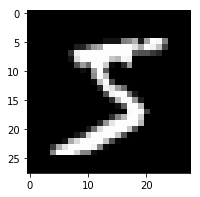

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Discriminator Network

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

### Generator Network

In [21]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

In [22]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [23]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

if train_on_gpu:
  D.cuda()
  G.cuda()

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [24]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
      labels = labels.cuda()
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
      labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [25]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [26]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

if train_on_gpu:
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        if train_on_gpu:
          real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
          z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
          z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3930 | g_loss: 0.7634
Epoch [    1/  100] | d_loss: 1.1092 | g_loss: 1.2795
Epoch [    1/  100] | d_loss: 1.2308 | g_loss: 1.0726
Epoch [    2/  100] | d_loss: 1.1205 | g_loss: 2.1765
Epoch [    2/  100] | d_loss: 1.5128 | g_loss: 0.8867
Epoch [    2/  100] | d_loss: 1.2064 | g_loss: 1.7956
Epoch [    3/  100] | d_loss: 1.3651 | g_loss: 0.8977
Epoch [    3/  100] | d_loss: 1.3144 | g_loss: 0.7506
Epoch [    3/  100] | d_loss: 1.3039 | g_loss: 0.8227
Epoch [    4/  100] | d_loss: 1.3451 | g_loss: 0.9112
Epoch [    4/  100] | d_loss: 1.3276 | g_loss: 0.7990
Epoch [    4/  100] | d_loss: 1.2228 | g_loss: 1.1806
Epoch [    5/  100] | d_loss: 1.1822 | g_loss: 1.5012
Epoch [    5/  100] | d_loss: 1.3538 | g_loss: 0.8984
Epoch [    5/  100] | d_loss: 1.2758 | g_loss: 0.8920
Epoch [    6/  100] | d_loss: 1.3238 | g_loss: 1.5725
Epoch [    6/  100] | d_loss: 1.4924 | g_loss: 0.7681
Epoch [    6/  100] | d_loss: 1.1635 | g_loss: 1.5400
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.3538 | g_loss: 0.8931
Epoch [   52/  100] | d_loss: 1.3114 | g_loss: 0.8837
Epoch [   52/  100] | d_loss: 1.3319 | g_loss: 0.8914
Epoch [   52/  100] | d_loss: 1.3884 | g_loss: 0.9097
Epoch [   53/  100] | d_loss: 1.2684 | g_loss: 1.5537
Epoch [   53/  100] | d_loss: 1.3274 | g_loss: 0.8755
Epoch [   53/  100] | d_loss: 1.4586 | g_loss: 1.0360
Epoch [   54/  100] | d_loss: 1.2324 | g_loss: 0.9873
Epoch [   54/  100] | d_loss: 1.3318 | g_loss: 0.9643
Epoch [   54/  100] | d_loss: 1.3840 | g_loss: 0.9316
Epoch [   55/  100] | d_loss: 1.2516 | g_loss: 1.4316
Epoch [   55/  100] | d_loss: 1.3337 | g_loss: 1.0175
Epoch [   55/  100] | d_loss: 1.4427 | g_loss: 1.1310
Epoch [   56/  100] | d_loss: 1.3668 | g_loss: 0.9536
Epoch [   56/  100] | d_loss: 1.3363 | g_loss: 0.8449
Epoch [   56/  100] | d_loss: 1.3673 | g_loss: 0.9256
Epoch [   57/  100] | d_loss: 1.3655 | g_loss: 0.8590
Epoch [   57/  100] | d_loss: 1.3473 | g_loss: 0.7989
Epoch [   57/  100] | d_loss

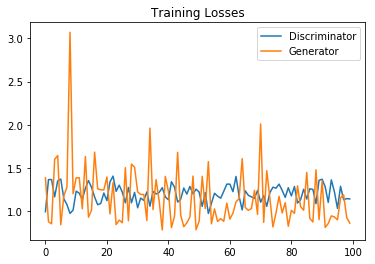

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [28]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.cpu().reshape((28,28)), cmap='Greys_r')

In [29]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

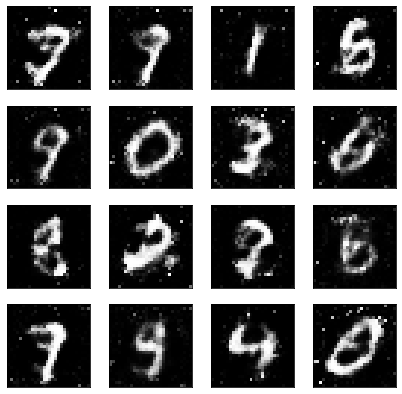

In [30]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)